In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy as np
import time
import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [3]:
torch.manual_seed(42)

In [4]:
train_df = pd.read_csv("D:\\Work\wsl\\ML-DS\\fashion-mnist\\fashion-mnist_train.csv")#.head(5000)
test_df = pd.read_csv("D:\\Work\wsl\\ML-DS\\fashion-mnist\\fashion-mnist_test.csv")#.head(1000)

In [5]:
print("train_df.count:",train_df.count())
print("test_df.count:", test_df.count())

train_df.count: label       60000
pixel1      60000
pixel2      60000
pixel3      60000
pixel4      60000
            ...  
pixel780    60000
pixel781    60000
pixel782    60000
pixel783    60000
pixel784    60000
Length: 785, dtype: int64
test_df.count: label       10000
pixel1      10000
pixel2      10000
pixel3      10000
pixel4      10000
            ...  
pixel780    10000
pixel781    10000
pixel782    10000
pixel783    10000
pixel784    10000
Length: 785, dtype: int64


In [6]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Converting to Numpy
X_train = train_df.iloc[:,1:].values
y_train = train_df.iloc[:,0].values

X_test = test_df.iloc[:,1:].values
y_test = test_df.iloc[:,0].values

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on training set
X_test_scaled = scaler.transform(X_test) 

In [10]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        super().__init__()
        self.features = torch.tensor(features, dtype=torch.float32)#.to(device=device)
        self.labels = torch.tensor(labels, dtype=torch.long)#.to(device=device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [11]:
train_dataset = CustomDataset(X_train_scaled, y_train)
test_dataset = CustomDataset(X_test_scaled, y_test)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)
num_cls = len(np.unique(y_train))

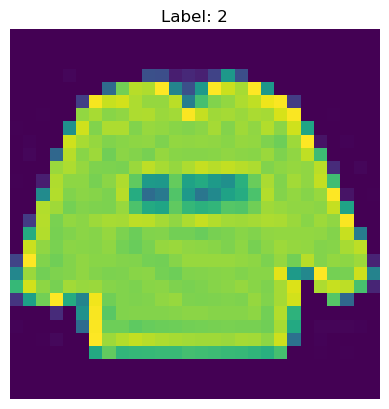

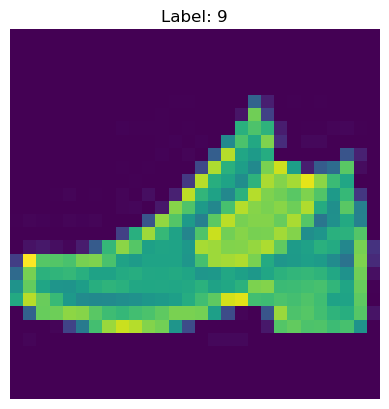

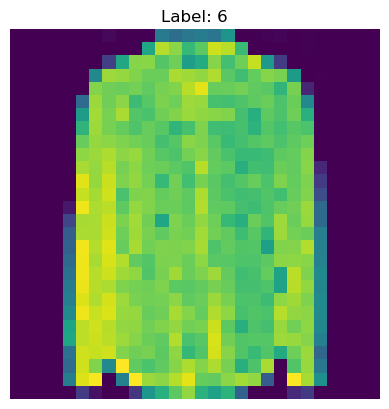

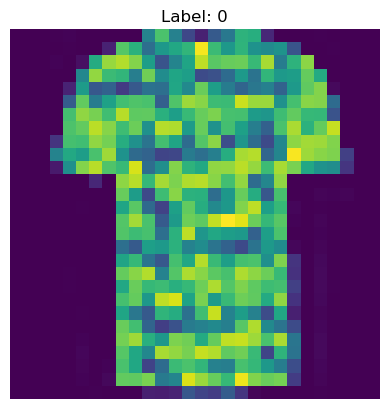

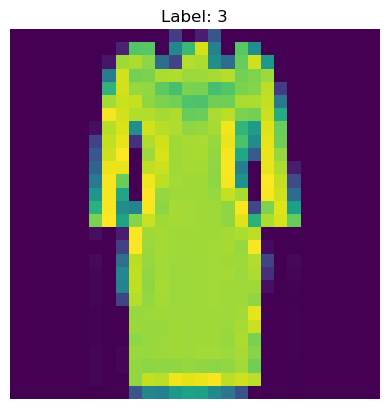

In [13]:
# Show the first 5 images in test_df
for i in range(5):
    img = train_df.iloc[i, 1:].values.reshape(28, 28)
    plt.imshow(img)#, cmap='gray')
    plt.title(f"Label: {train_df.iloc[i, 0]}")
    plt.axis('off')
    plt.show()

In [14]:
class MyANN(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        print(num_features)
        self.model = nn.Sequential(nn.Linear(num_features, 256),
                                   nn.BatchNorm1d(256),
                                   nn.ReLU(),
                                   nn.Dropout(.3),
                                   nn.Linear(256, 128), 
                                   nn.BatchNorm1d(128),
                                   nn.ReLU(),
                                   nn.Dropout(.3),
                                   nn.Linear(128, 64),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),   
                                   nn.Dropout(.3),
                                   nn.Linear(64, num_cls)
                                   )
    def forward(self, x) :
        return self.model(x)

In [15]:
model = MyANN(num_features=X_train.shape[1]).to(device=device)

784


In [16]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [17]:

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
        elif val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def restore_best_weights(self, model):
        model.load_state_dict(self.best_model_state)



In [18]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
regularization_coff = 1e-4
model.apply(init_weights)
optimizer = optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay = regularization_coff)

In [19]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',        # Reduce when validation loss stops decreasing
    factor=0.1,        # New LR = old LR * factor
    patience=5,        # Number of epochs with no improvement
    min_lr=1e-5,       # Lower bound on the learning rate
    verbose=True
)

d:\Work\miniconda_env\hf-pytorch\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
early_stopping = EarlyStopping(patience=3, min_delta=0.0001)

epochs = 1000
start_time = time.time()
for epoch in range(epochs):

    model.train()
    total_epoch_loss = 0

    for batch_features, batch_labels in train_loader:
        
        batch_features, batch_labels = batch_features.to(device, non_blocking=True), batch_labels.to(device, non_blocking=True)

        outputs= model(batch_features)

        loss = criterion(outputs, batch_labels)
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_epoch_loss = total_epoch_loss + loss.item()

    avg_loss = total_epoch_loss/len(train_loader)
    print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:

            batch_features, batch_labels = batch_features.to(device, non_blocking=True), batch_labels.to(device, non_blocking=True)

            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_losses.append(loss.item())
    
    mean_val_loss = sum(val_losses) / len(val_losses)
    print(f"Epoch {epoch+1}, Validation Loss: {mean_val_loss:.4f}")

    scheduler.step(mean_val_loss)
    
    early_stopping(mean_val_loss, model=model)
    if early_stopping.early_stop:
        print("Early stopping triggered! Stopping training.")
        break

print(f"Best Validation Loss: {early_stopping.best_score:.4f}")

early_stopping.restore_best_weights(model=model)

end_time = time.time()
elapsed_seconds = end_time - start_time

hours = int(elapsed_seconds // 3600)
minutes = int((elapsed_seconds % 3600) // 60)
seconds = int(elapsed_seconds % 60)

print(f"Elapsed time: {hours} hours, {minutes} minutes, {seconds} seconds")

Epoch: 1 , Loss: 0.6748140050649643
Epoch 1, Validation Loss: 0.4027
Epoch: 2 , Loss: 0.4910639627456665
Epoch 2, Validation Loss: 0.3695
Epoch: 3 , Loss: 0.44345504629214605
Epoch 3, Validation Loss: 0.3392
Epoch: 4 , Loss: 0.4215370431741079
Epoch 4, Validation Loss: 0.3263
Epoch: 5 , Loss: 0.4010418595393499
Epoch 5, Validation Loss: 0.3304
Epoch: 6 , Loss: 0.3832959579149882
Epoch 6, Validation Loss: 0.3155
Epoch: 7 , Loss: 0.37232948488990464
Epoch 7, Validation Loss: 0.3076
Epoch: 8 , Loss: 0.35885510523716607
Epoch 8, Validation Loss: 0.3119
Epoch: 9 , Loss: 0.3512431199391683
Epoch 9, Validation Loss: 0.2915
Epoch: 10 , Loss: 0.3374540823618571
Epoch 10, Validation Loss: 0.2976
Epoch: 11 , Loss: 0.332686839534839
Epoch 11, Validation Loss: 0.2864
Epoch: 12 , Loss: 0.32637600246866544
Epoch 12, Validation Loss: 0.2838
Epoch: 13 , Loss: 0.3211520439704259
Epoch 13, Validation Loss: 0.2820
Epoch: 14 , Loss: 0.31354596300323806
Epoch 14, Validation Loss: 0.2781
Epoch: 15 , Loss: 0.

In [21]:
model.eval()
total = 0
correct = 0

for batch_features, batch_labels in test_loader:

    batch_features, batch_labels = batch_features.to(device, non_blocking=True), batch_labels.to(device, non_blocking=True)

    outputs = model(batch_features)
    _, pred = torch.max(outputs, 1)
    total += batch_labels.shape[0]
    correct += (pred == batch_labels).sum().item()

print("Total:", total)
print("Corrected:", correct)
print("Accuracy:", (correct/total) * 100)

Total: 10000
Corrected: 9003
Accuracy: 90.03
